使用带reconstruction loss的条件变分自编码器生成MNIST数据
===

In [1]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# 1.全局设置

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Hyperparameters
random_seed = 0
learning_rate = 0.001
num_epochs = 50
batch_size = 128

# Architecture
num_classes = 10
num_features = 784
num_hidden_1 = 500
num_latent = 35

Device: cuda:0


# 2.导入数据

In [3]:
train_dataset = datasets.MNIST(root='/input/MNIST/', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='/input/MNIST/', 
                              train=False, 
                              transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# 3.模型

In [4]:
def to_onehot(labels, num_classes, device):

    labels_onehot = torch.zeros(labels.size()[0], num_classes).to(device)
    labels_onehot.scatter_(1, labels.view(-1, 1), 1)

    return labels_onehot


class ConditionalVariationalAutoencoder(torch.nn.Module):

    def __init__(self, num_features, num_hidden_1, num_latent, num_classes):
        super(ConditionalVariationalAutoencoder, self).__init__()
        
        self.num_classes = num_classes
        
        ### ENCODER
        self.hidden_1 = torch.nn.Linear(num_features+num_classes, num_hidden_1)
        self.z_mean = torch.nn.Linear(num_hidden_1, num_latent)
        # in the original paper (Kingma & Welling 2015, we use
        # have a z_mean and z_var, but the problem is that
        # the z_var can be negative, which would cause issues
        # in the log later. Hence we assume that latent vector
        # has a z_mean and z_log_var component, and when we need
        # the regular variance or std_dev, we simply use 
        # an exponential function
        self.z_log_var = torch.nn.Linear(num_hidden_1, num_latent)
        
        
        ### DECODER
        self.linear_3 = torch.nn.Linear(num_latent+num_classes, num_hidden_1)
        self.linear_4 = torch.nn.Linear(num_hidden_1, num_features+num_classes)

    def reparameterize(self, z_mu, z_log_var):
        # Sample epsilon from standard normal distribution
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        # note that log(x^2) = 2*log(x); hence divide by 2 to get std_dev
        # i.e., std_dev = exp(log(std_dev^2)/2) = exp(log(var)/2)
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def encoder(self, features, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        x = torch.cat((features, onehot_targets), dim=1)

        ### ENCODER
        x = self.hidden_1(x)
        x = F.leaky_relu(x)
        z_mean = self.z_mean(x)
        z_log_var = self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return z_mean, z_log_var, encoded
    
    def decoder(self, encoded, targets):
        ### Add condition
        onehot_targets = to_onehot(targets, self.num_classes, device)
        encoded = torch.cat((encoded, onehot_targets), dim=1)        
        
        ### DECODER
        x = self.linear_3(encoded)
        x = F.leaky_relu(x)
        x = self.linear_4(x)
        decoded = torch.sigmoid(x)
        return decoded

    def forward(self, features, targets):
        
        z_mean, z_log_var, encoded = self.encoder(features, targets)
        decoded = self.decoder(encoded, targets)
        
        return z_mean, z_log_var, encoded, decoded

    
torch.manual_seed(random_seed)
model = ConditionalVariationalAutoencoder(num_features,
                                          num_hidden_1,
                                          num_latent,
                                          num_classes)
model = model.to(device)
    

##########################
### COST AND OPTIMIZER
##########################

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

# 4.训练

In [5]:
start_time = time.time()
for epoch in range(num_epochs):
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.view(-1, 28*28).to(device)
        targets = targets.to(device)

        ### FORWARD AND BACK PROP
        z_mean, z_log_var, encoded, decoded = model(features, targets)

        # cost = reconstruction loss + Kullback-Leibler divergence
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_log_var) - z_log_var - 1)).sum()
        
        # add condition
        x_con = torch.cat((features, to_onehot(targets, num_classes, device)), dim=1)
        
        pixelwise_bce = F.binary_cross_entropy(decoded, x_con, reduction='sum')
        cost = kl_divergence + pixelwise_bce
        
        optimizer.zero_grad()
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader)//batch_size, cost))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/050 | Batch 000/003 | Cost: 71038.5859
Epoch: 001/050 | Batch 050/003 | Cost: 27687.3008
Epoch: 001/050 | Batch 100/003 | Cost: 22472.5020
Epoch: 001/050 | Batch 150/003 | Cost: 20544.7617
Epoch: 001/050 | Batch 200/003 | Cost: 19683.6660
Epoch: 001/050 | Batch 250/003 | Cost: 18074.9707
Epoch: 001/050 | Batch 300/003 | Cost: 18203.2344
Epoch: 001/050 | Batch 350/003 | Cost: 17165.5078
Epoch: 001/050 | Batch 400/003 | Cost: 17114.0586
Epoch: 001/050 | Batch 450/003 | Cost: 16487.2949
Time elapsed: 0.23 min
Epoch: 002/050 | Batch 000/003 | Cost: 16559.8652
Epoch: 002/050 | Batch 050/003 | Cost: 15921.1240
Epoch: 002/050 | Batch 100/003 | Cost: 15625.4014
Epoch: 002/050 | Batch 150/003 | Cost: 15649.0459
Epoch: 002/050 | Batch 200/003 | Cost: 15254.8516
Epoch: 002/050 | Batch 250/003 | Cost: 15594.6016
Epoch: 002/050 | Batch 300/003 | Cost: 14560.8770
Epoch: 002/050 | Batch 350/003 | Cost: 15119.7002
Epoch: 002/050 | Batch 400/003 | Cost: 14817.9355
Epoch: 002/050 | Batch 450/

Epoch: 016/050 | Batch 350/003 | Cost: 12401.6191
Epoch: 016/050 | Batch 400/003 | Cost: 12595.4326
Epoch: 016/050 | Batch 450/003 | Cost: 12107.5537
Time elapsed: 3.55 min
Epoch: 017/050 | Batch 000/003 | Cost: 12960.3457
Epoch: 017/050 | Batch 050/003 | Cost: 12457.1523
Epoch: 017/050 | Batch 100/003 | Cost: 12965.4639
Epoch: 017/050 | Batch 150/003 | Cost: 12897.5361
Epoch: 017/050 | Batch 200/003 | Cost: 12363.3340
Epoch: 017/050 | Batch 250/003 | Cost: 12938.4443
Epoch: 017/050 | Batch 300/003 | Cost: 12360.8496
Epoch: 017/050 | Batch 350/003 | Cost: 12681.3809
Epoch: 017/050 | Batch 400/003 | Cost: 12350.6475
Epoch: 017/050 | Batch 450/003 | Cost: 12862.7539
Time elapsed: 3.77 min
Epoch: 018/050 | Batch 000/003 | Cost: 12521.2129
Epoch: 018/050 | Batch 050/003 | Cost: 12492.9082
Epoch: 018/050 | Batch 100/003 | Cost: 12475.2148
Epoch: 018/050 | Batch 150/003 | Cost: 12769.4404
Epoch: 018/050 | Batch 200/003 | Cost: 12666.2959
Epoch: 018/050 | Batch 250/003 | Cost: 12225.7500
Epoc

Epoch: 032/050 | Batch 200/003 | Cost: 12936.3994
Epoch: 032/050 | Batch 250/003 | Cost: 12967.5859
Epoch: 032/050 | Batch 300/003 | Cost: 12356.9346
Epoch: 032/050 | Batch 350/003 | Cost: 13171.0479
Epoch: 032/050 | Batch 400/003 | Cost: 12499.7266
Epoch: 032/050 | Batch 450/003 | Cost: 12477.6670
Time elapsed: 7.09 min
Epoch: 033/050 | Batch 000/003 | Cost: 12492.4658
Epoch: 033/050 | Batch 050/003 | Cost: 12623.8398
Epoch: 033/050 | Batch 100/003 | Cost: 11807.7910
Epoch: 033/050 | Batch 150/003 | Cost: 12849.6201
Epoch: 033/050 | Batch 200/003 | Cost: 12311.3965
Epoch: 033/050 | Batch 250/003 | Cost: 12439.0146
Epoch: 033/050 | Batch 300/003 | Cost: 12895.8799
Epoch: 033/050 | Batch 350/003 | Cost: 12367.8486
Epoch: 033/050 | Batch 400/003 | Cost: 12708.3477
Epoch: 033/050 | Batch 450/003 | Cost: 12414.6738
Time elapsed: 7.31 min
Epoch: 034/050 | Batch 000/003 | Cost: 12659.3398
Epoch: 034/050 | Batch 050/003 | Cost: 12585.5664
Epoch: 034/050 | Batch 100/003 | Cost: 12693.0000
Epoc

Epoch: 048/050 | Batch 050/003 | Cost: 12731.8721
Epoch: 048/050 | Batch 100/003 | Cost: 11994.5879
Epoch: 048/050 | Batch 150/003 | Cost: 12093.6475
Epoch: 048/050 | Batch 200/003 | Cost: 11609.1504
Epoch: 048/050 | Batch 250/003 | Cost: 12529.5059
Epoch: 048/050 | Batch 300/003 | Cost: 12153.3594
Epoch: 048/050 | Batch 350/003 | Cost: 12875.9170
Epoch: 048/050 | Batch 400/003 | Cost: 12760.4492
Epoch: 048/050 | Batch 450/003 | Cost: 12162.4766
Time elapsed: 10.63 min
Epoch: 049/050 | Batch 000/003 | Cost: 12410.0459
Epoch: 049/050 | Batch 050/003 | Cost: 12377.5928
Epoch: 049/050 | Batch 100/003 | Cost: 12393.7012
Epoch: 049/050 | Batch 150/003 | Cost: 12823.0137
Epoch: 049/050 | Batch 200/003 | Cost: 12030.5088
Epoch: 049/050 | Batch 250/003 | Cost: 12269.9053
Epoch: 049/050 | Batch 300/003 | Cost: 12200.3828
Epoch: 049/050 | Batch 350/003 | Cost: 12820.2969
Epoch: 049/050 | Batch 400/003 | Cost: 11907.7383
Epoch: 049/050 | Batch 450/003 | Cost: 12440.8887
Time elapsed: 10.85 min
Ep

# 5.评估

## 5.1.重构

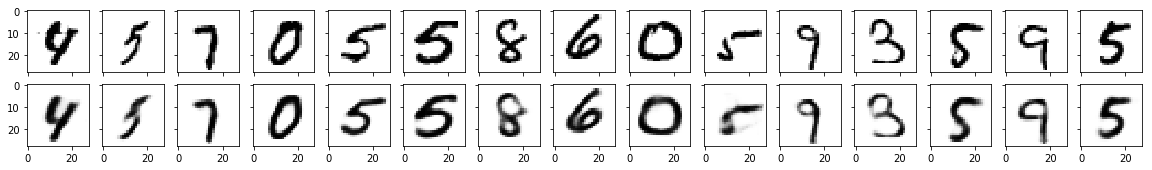

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = decoded[:n_images][:, :-num_classes]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')

## 5.2.生成

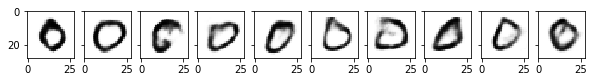

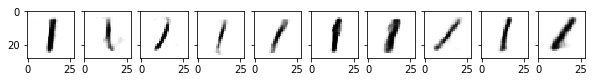

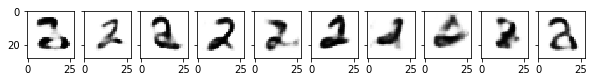

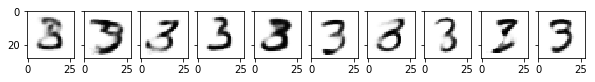

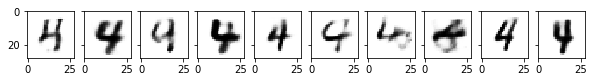

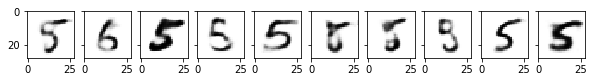

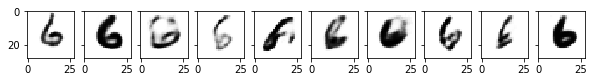

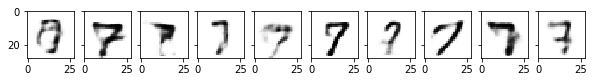

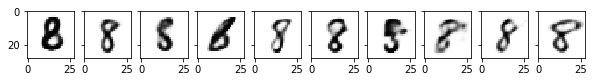

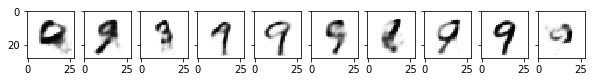

In [8]:
for i in range(10):

    ##########################
    ### RANDOM SAMPLE
    ##########################    
    
    labels = torch.tensor([i]*10).to(device)
    n_images = labels.size()[0]
    rand_features = torch.randn(n_images, num_latent).to(device)
    new_images = model.decoder(rand_features, labels)

    ##########################
    ### VISUALIZATION
    ##########################

    image_width = 28

    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=(10, 2.5), sharey=True)
    decoded_images = new_images[:n_images][:, :-num_classes]

    for ax, img in zip(axes, decoded_images):
        curr_img = img.detach().to(torch.device('cpu'))
        ax.imshow(curr_img.view((image_width, image_width)), cmap='binary')